In [27]:
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from astropy.table import Table
from astropy.io import fits
import h5py
from Payne.fitting.genmod import GenMod

import os
import csv

In [55]:
def gensynthspec(specNN='', NNtype='', starpars=([]), plot=False):

    # Read in model spectrum parameters
    # model_filename = os.path.expanduser(model_filename)
    # data, header = fits.getdata(model_filename, header=True)

    # define desired parameters
    if starpars:
        print(f"Spectral parameters:\n[Teff, log(g), [Fe/H], [a/Fe], vrad, vstar, vmic, lsf (R), pc0, pc1, pc2, pc3]\n{starpars}")
    else:
        starpars = ([
                1, # Teff
                1, # log(g)
                1, # [Fe/H]
                1, # [a/Fe]
                1, # vrad
                1, # vstar
                1, # vmic
                1, # lsf (R)
                1, # pc0
                1, # pc1
                1, # pc2
                1, # pc3
        ])
        print(f"Spectral parameters:\n[Teff, log(g), [Fe/H], [a/Fe], vrad, vstar, vmic, lsf (R), pc0, pc1, pc2, pc3]\n{starpars}")
    Teff = starpars[0]

    # initialize model generation class
    GM = GenMod()
    GM._initspecnn(
        nnpath=specNN,
        NNtype=NNtype)
    
    # generate the model, output is an array of [wave,flux]
    specmod = GM.genspec(starpars, modpoly=True)
    
    # plot the synthetic spectrum
    fig, ax = plt.subplots()

    if plot:
        # plot the model
        ax.plot(specmod[0], specmod[1], c='C3')
    
        # wave_min = np.amin(specmod[0])
        # wave_max = np.amax(specmod[1])
        # ax.set_xlim(int(wave_min), int(wave_max))
    
        ax.set_xlabel(r'$\lambda$')
        ax.set_ylabel(r"$F_{\lambda}$")
        ax.set_title('Synthetic Spectrum')
    
        plt.show()
        # plt.savefig(f"synth_spec_T{int(Teff)}.png")

    # output spectrum to csv
    with open(f'synth_spec_T{int(Teff)}.csv','w') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['wave','flux'])

        for row in zip(specmod[0], specmod[1]):
            csv_out.writerow(row)
        # csv_out.writerows(specmod)

Parameters:
[Teff, log(g), [Fe/H], [a/Fe], vrad, vstar, vmic, lsf (R), pc0, pc1, pc2, pc3]
[5564.35, 4.16, -0.12, 0.11, -98.13, 2.74, 1.0, 32007.42, 1.08, 0.06, 0.0, 0.0]


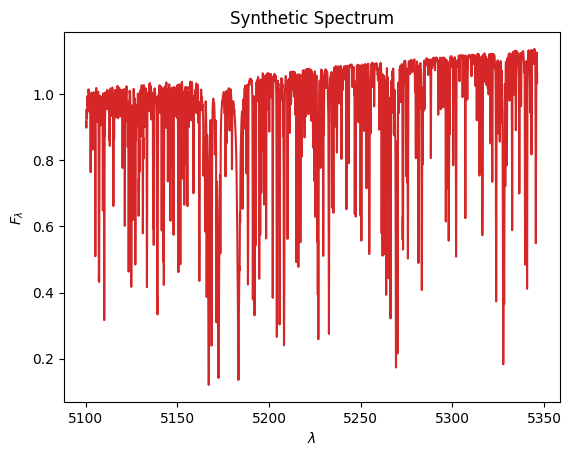

In [56]:
specNN='/data/labs/douglaslab/sofairj/demo4/models/specNN/modV0_spec_LinNet_R42K_WL510_535_wvt.h5'
NNtype='LinNet'
starpars = ([
            5564.35, # Teff
            4.16, # log(g)
            -0.12, # [Fe/H]
            0.11, # [a/Fe]
            3.47, # vrad
            2.74, # vstar
            1.0, # vmic
            32007.42, # lsf (R)
            1.08, # pc0
            0.06, # pc1
            0.0, # pc2
            0.0, # pc3
    ])

gensynthspec(specNN=specNN, NNtype=NNtype, starpars=starpars, plot=True)

In [101]:
def gensynthphot(photNN='', NNtype='', starpars=([]), filtarr='', plot=True):



    if starpars:
        print(f"Photometric parameters:\n[Teff, log(g), [Fe/H], [a/Fe], log(R), dist, Av, Rv (3.1)]\n{starpars}")
    else:
        starpars = ([
                1, # Teff
                1, # log(g)
                1, # [Fe/H]
                1, # [a/Fe]
                1, # log(R)
                1, # Dist
                1, # Av
                3.1 # Rv (3.1)
        ])
        print(f"Photometric parameters:\n[Teff, log(g), [Fe/H], [a/Fe], log(R), dist, Av, Rv (3.1)]\n{starpars}")
    
    Teff = starpars[0]

    # initialize model generation class
    GM = GenMod()
    GM._initphotnn(
        filterarray=filtarr,
        nnpath=photNN
    )

    # generate the model, output is an array of [wave,flux]
            # def genphot(self,pars,rvfree=False,verbose=False):
    photmod = GM.genphot(starpars)
    print(photmod)
    photmod = [photmod[xx] for xx in filtarr]
    print(photmod)
    

    # photpars_a = ([
    #     sample_i['Teff_a'],sample_i['log(g)_a'],sample_i['[Fe/H]_a'],sample_i['[a/Fe]_a'],
    #     sample_i['log(R)_a'],sample_i['dist'],sample_i['Av'],3.1])
    # photmod_a = genphotfn(photpars_a)
    # photmod_a = [photmod_a[xx] for xx in filtarray]

    
    
    # plot the synthetic photometry
    fig, ax = plt.subplots()

    if plot:
        # plot the model
        ax.plot(photmod[0], photmod[1], c='C3')
    
        # wave_min = np.amin(photmod[0])
        # wave_max = np.amax(photmod[1])
        # ax.set_xlim(int(wave_min), int(wave_max))
    
        ax.set_xlabel(r'$\lambda$')
        ax.set_ylabel(r"$F_{\lambda}$")
        ax.set_title('Synthetic Photometry')
    
        plt.show()
        # plt.savefig(f"synth_spec_T{int(Teff)}.png")

    # # output spectrum to csv
    # with open(f'synth_spec_T{int(Teff)}.csv','w') as out:
    #     csv_out=csv.writer(out)
    #     csv_out.writerow(['wave','flux'])

    #     for row in zip(photmod[0], photmod[1]):
    #         csv_out.writerow(row)
    #     # csv_out.writerows(photmod)

Photometric parameters:
[Teff, log(g), [Fe/H], [a/Fe], log(R), dist, Av, Rv (3.1)]
[5564.35, 4.16, -0.12, 0.11, 3.47, 2.74, 1.0, 3.1]
{'2MASS_H': -16.637890924089547, '2MASS_J': -16.175446561166957, '2MASS_Ks': -16.7349998115222, 'PS_g': -13.789127976469755, 'PS_i': -14.885809065278274, 'PS_r': -14.520227531090923, 'PS_z': -15.064029344687393, 'GaiaDR3_BP': -13.96255753187274, 'GaiaDR3_RP': -15.256110508864127, 'GaiaDR3_G': -14.523272733307845}
[-16.637890924089547, -16.175446561166957, -16.7349998115222, -13.789127976469755, -14.885809065278274, -14.520227531090923, -15.064029344687393, -13.96255753187274, -15.256110508864127, -14.523272733307845]


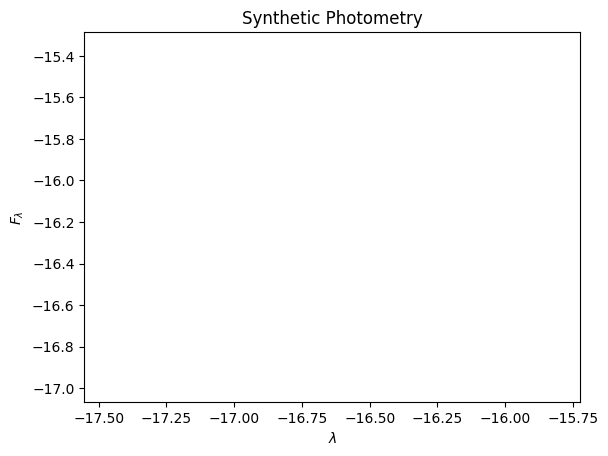

In [102]:
photNN='/data/labs/douglaslab/sofairj/demo4/models/photNN/'
NNtype='LinNet'
starpars = ([
            5564.35, # Teff
            4.16, # log(g)
            -0.12, # [Fe/H]
            0.11, # [a/Fe]
            3.47, # log(R)
            2.74, # dist
            1.0, # Av
            3.1, # lsf (R)
    ])
filtarr = ['2MASS_H', '2MASS_J', '2MASS_Ks', 'PS_g', 'PS_i', 'PS_r', 'PS_z', 'GaiaDR3_BP', 'GaiaDR3_RP', 'GaiaDR3_G']

gensynthphot(photNN=photNN, NNtype=NNtype, starpars=starpars, filtarr=filtarr, plot=True)